# Perturbing simulations in the basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

In [6]:
def imshow3(etahuhv, negative_vlim=True,  eta_vlim=0.05, huv_vlim=2, cmap="coolwarm", title=None):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    fig.suptitle(title, y=0.85)

    im = axs[0].imshow(etahuhv[0], vmin=-negative_vlim*eta_vlim, vmax=eta_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[0], shrink=0.5)
    axs[0].set_title("$\eta$", fontsize=15)

    im = axs[1].imshow(etahuhv[1], vmin=-negative_vlim*huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[1], shrink=0.5)
    axs[1].set_title("$hu$", fontsize=15)

    im = axs[2].imshow(etahuhv[2], vmin=-negative_vlim*huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[2], shrink=0.5)
    axs[2].set_title("$hv$", fontsize=15)

    return fig, axs

In [7]:
def imshow3var(est_var, eta_vlim=0.00025, huv_lim=1.0):
    return imshow3(est_var, negative_vlim=False, eta_vlim=eta_vlim, huv_vlim=huv_lim, cmap="Reds")

In [8]:
def imshowSim(sim, **kvargs):
    eta, hu, hv = sim.download(interior_domain_only=True)
    return imshow3(np.array([eta, hu, hv]), **kvargs)

### Perturbing initial conditions

In [9]:
sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

In [10]:
ls = [6, 7, 8, 9, 10]

In [11]:
model_error_args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    model_error_args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [12]:
model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 6,
    "basis_y_start": 2,
    "basis_y_end": 7,

    "kl_decay": 1.25,
    "kl_scaling": 0.005,
}

In [13]:
mekls = []
for l_idx in range(len(ls)): 
    mekls.append( ModelErrorKL.ModelErrorKL(**model_error_args_list[l_idx], **model_error_basis_args) 
                )

Make a sim with initial perturbations

In [14]:
sim = make_sim(model_error_args_list[-1], sample_args)
mekls[-1].perturbSim(sim)

In [15]:
init_eta, init_hu, init_hv = sim.download()

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

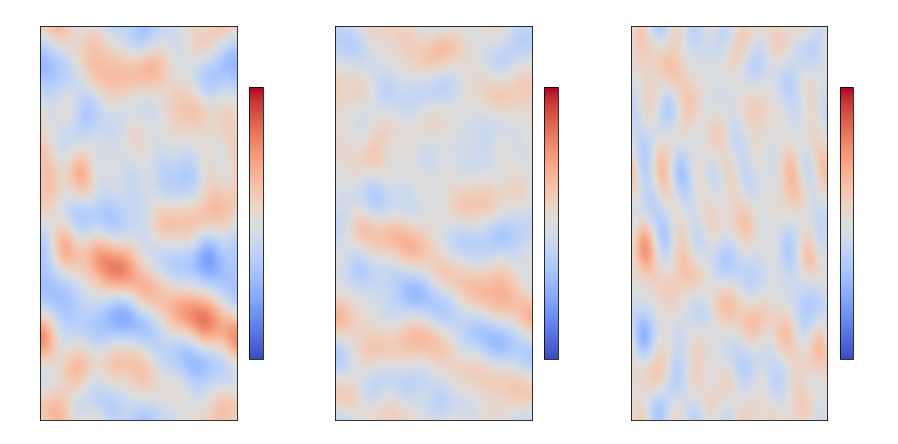

In [16]:
imshowSim(sim, eta_vlim=0.01, huv_vlim=1 )

In [17]:
coarse_sim = make_sim(model_error_args_list[-2], sample_args)
mekls[-2].perturbSimSimilarAs(coarse_sim, modelError=mekls[-1])

In [18]:
coarse_init_eta, coarse_init_hu, coarse_init_hv = coarse_sim.download()

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

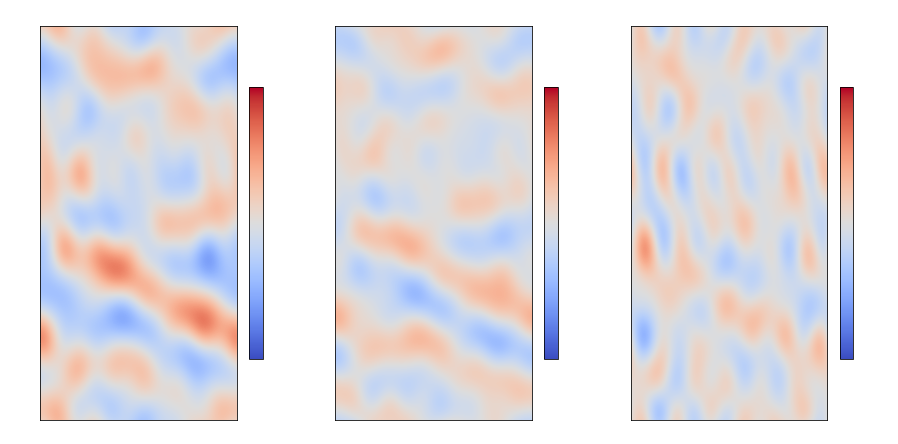

In [19]:
imshowSim(coarse_sim, eta_vlim=0.01, huv_vlim=1 )

### Simulating in time

In [20]:
sim.step(3600)

3600.0

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

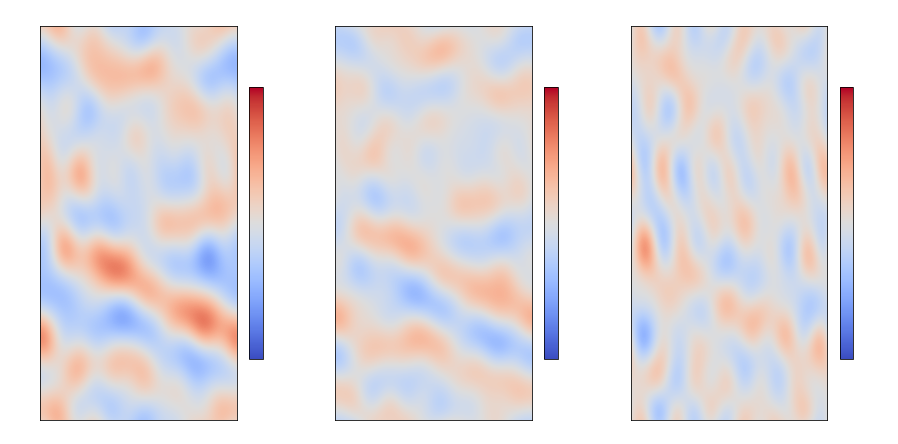

In [21]:
imshowSim(sim, eta_vlim=0.01, huv_vlim=1 )

In [22]:
final_eta, final_hu, final_hv = sim.download()

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

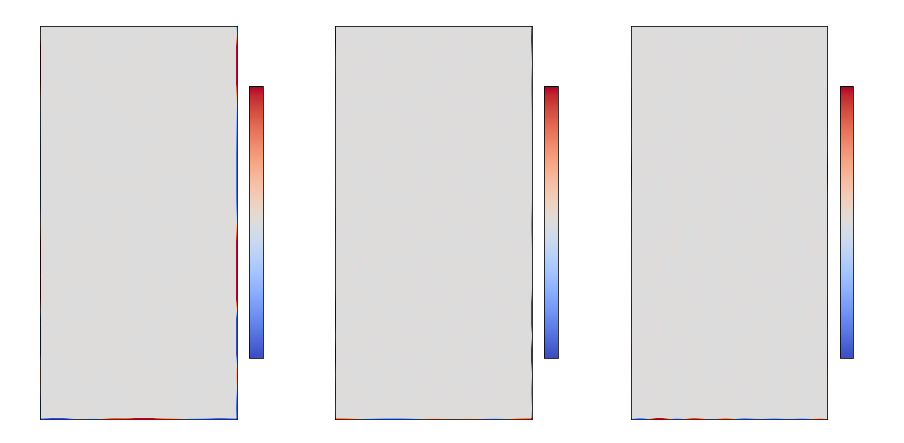

In [23]:
imshow3(np.array([init_eta,init_hu,init_hv]) - np.array([final_eta,final_hu,final_hv]), eta_vlim=0.001, huv_vlim=0.1)

### Perturbing Ocean State

In [24]:
sim_model_error_basis_args = {
    "basis_x_start": 2, 
    "basis_x_end": 7,
    "basis_y_start": 3,
    "basis_y_end": 8,

    "kl_decay": 1.25,
    "kl_scaling": 0.0005,
}


In [25]:
sim = make_sim(model_error_args_list[-1], sample_args)
sim.upload(init_eta, init_hu, init_hv)

In [26]:
coarse_sim = make_sim(model_error_args_list[-2], sample_args)
coarse_sim.upload(coarse_init_eta, coarse_init_hu, coarse_init_hv)

In [27]:
sim.setKLModelError(**sim_model_error_basis_args)
coarse_sim.setKLModelErrorSimilarAs(sim)

In [28]:
sim.model_time_step = 60

In [29]:
sim.t

0.0

In [30]:
sim.dataAssimilationStep(3600, otherSim=coarse_sim)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

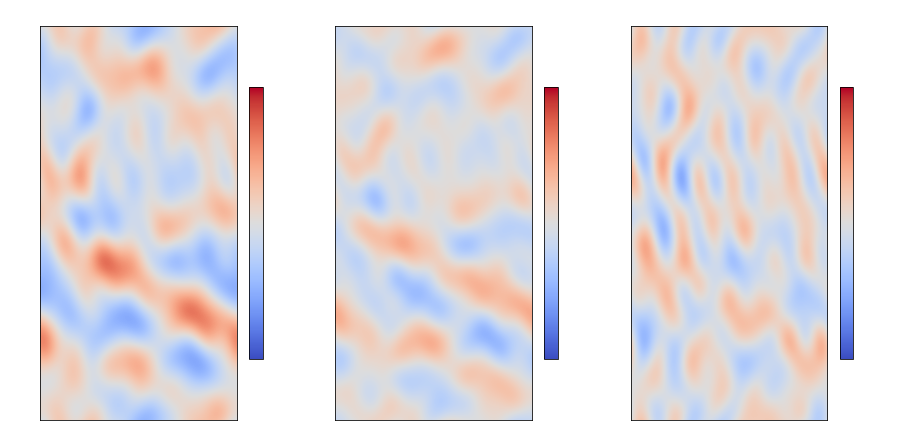

In [31]:
imshowSim(sim, eta_vlim=0.01, huv_vlim=1 )

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

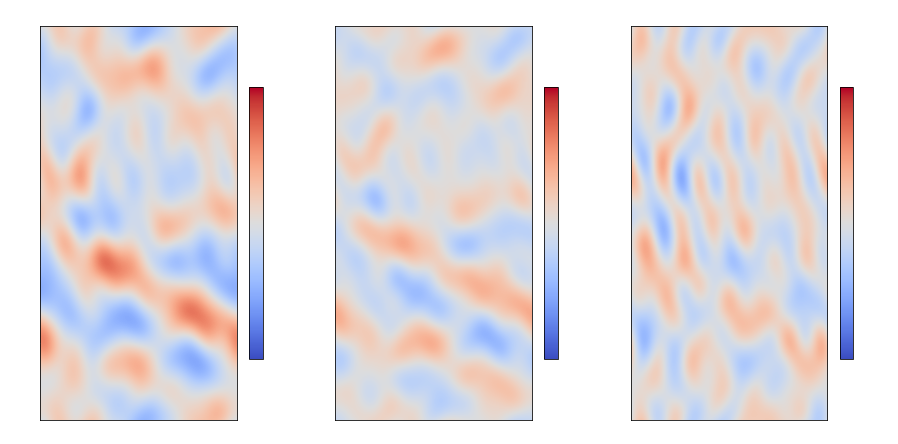

In [32]:
imshowSim(coarse_sim, eta_vlim=0.01, huv_vlim=1 )

In [33]:
coarse_sim.t

3600.0

### Compare

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

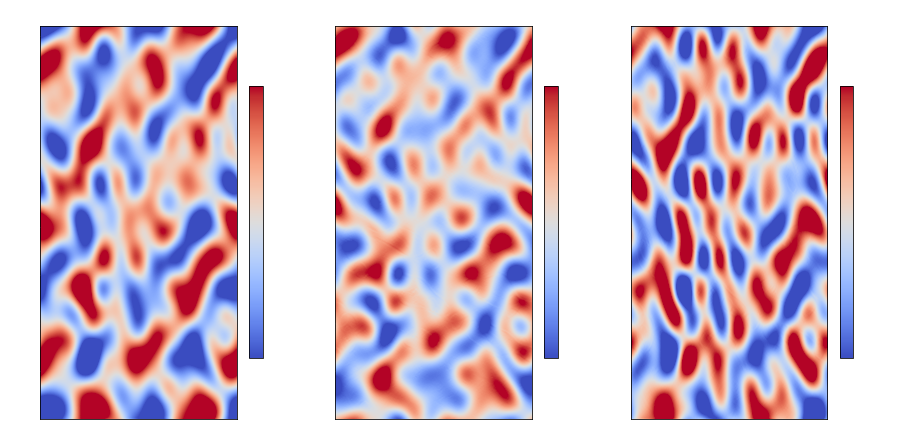

In [34]:
imshow3(np.array(sim.download()) - np.array([final_eta,final_hu,final_hv]), eta_vlim=0.001, huv_vlim=0.1)